Generate passband displays from the data captured during system health check

In [35]:
import os
import numpy as np
import katfile
import katarchive
import matplotlib.pyplot as plt
%matplotlib inline

Process the latest file (assumption: returned archive list returns latest file first)

In [36]:
fn = katarchive.search_archive(description='health')
# Proc ess the latest file (assumption: returned archive list returns latest file first)
x=fn[0]
path=x.metadata.FileLocation
name=x.metadata.Details[116:130]
fullname=path+name
h5 = katfile.open(fullname)
#nice_filename = os.path.splitext(os.path.basename(fn[0].path_to_file))[0]
#print nice_filename


Searched using: CAS.ProductTypeName:(KatFile) AND CAS.ProductTransferStatus:RECEIVED AND Description:health
Returning 318 results


Add summary description to report

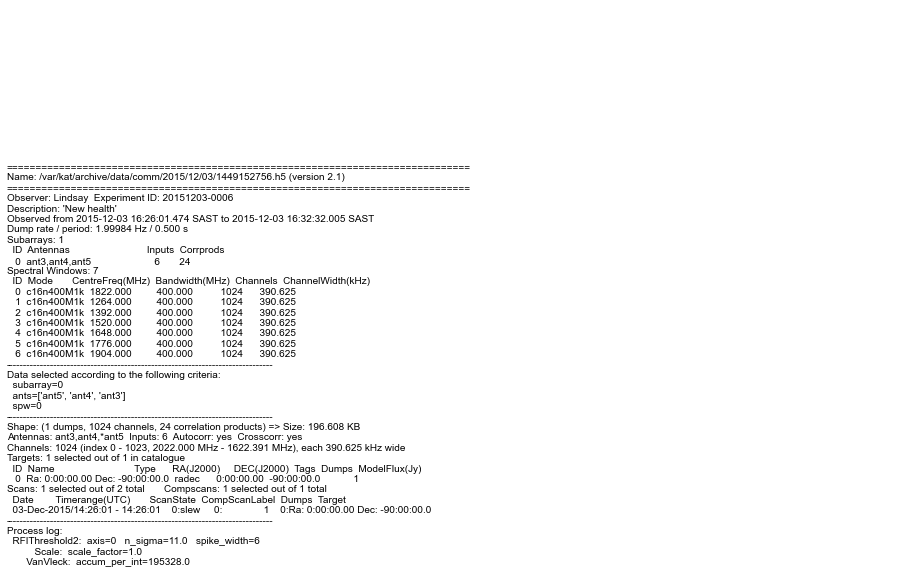

In [37]:
plt.figure(figsize = (16,10))
plt.plot([0,1],'w')
plt.axes(frame_on=False)
plt.xticks([])
plt.yticks([])
plt.text(0,0,h5.__str__())
plt.show()

In [38]:
cor = h5.corr_products
ch = slice(len(h5.channels)/2 - int(len(h5.channels)*128e6/400e6),len(h5.channels)/2 + int(len(h5.channels)*128e6/400e6))
colors = ('b', 'r', 'k', 'c', 'm', 'y', 'g')
ants = h5.ants
num_ants = len(ants)

code to plot the cross spectra

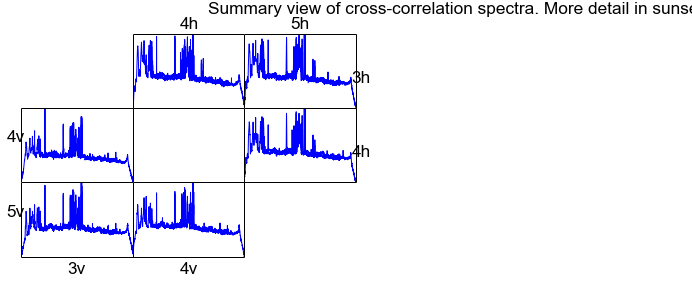

In [39]:
fig = plt.figure()
fringes=[]
freqs = []
data = []
n_spw = len(h5.spectral_windows)
for sw in range(n_spw):
  try:
    h5.select(spw=sw,scans='track',channels = ch)
    n_channels = len(h5.channels)
    df = h5.channel_width
    f_c = h5.spectral_windows[sw].centre_freq
    f_ind = h5.channel_freqs
    freqs.append(f_ind)
    for pol in ('h','v'):
      h5.select(corrprods = 'cross',pol=pol)
      crosscorr = [(h5.inputs.index(inpA), h5.inputs.index(inpB)) for inpA, inpB in h5.corr_products]
      data.append(h5.vis[:])
      fringes.append(np.angle(data[-1]))
      power = np.abs(data[-1])
      dB_power = 10 * np.log10(np.median(power,0))
      #For plotting the spectra
      fig.subplots_adjust(wspace=0., hspace=0.)
      for n, (indexA, indexB) in enumerate(crosscorr):
        subplot_index = (num_ants * indexA + indexB + 1) if pol == 'h' else (indexA + num_ants * indexB + 1)
        ax = fig.add_subplot(num_ants, num_ants, subplot_index)
        ax.plot(f_ind,dB_power[:,n],'b')
        ax.set_xticks([])
        ax.set_yticks([])
        if pol == 'h':
            if indexA == 0:
              ax.xaxis.set_label_position('top')
              ax.set_xlabel(h5.inputs[indexB][3:],size='xx-large')
            if indexB == len(h5.ants) - 1:
              ax.yaxis.set_label_position('right')
              ax.set_ylabel(h5.inputs[indexA][3:], rotation='horizontal',size = 'xx-large')
        else:
            if indexA == 0:
              ax.set_ylabel(h5.inputs[indexB][3:], rotation='horizontal',size='xx-large')
            if indexB == len(h5.ants) - 1:
              ax.set_xlabel(h5.inputs[indexA][3:],size='xx-large')
  except KeyError , error:
      print 'Failed to read scans from File: ',fn[0].path_to_file,' with Key Error:',error
  except ValueError , error:
      print 'Failed to read scans from File: ',fn[0].path_to_file,' with Value Error:',error
plt.annotate('Summary view of cross-correlation spectra. More detail in sunsequent pages.',(0.2,0.95),xycoords='figure fraction',xytext=(0.3, 0.95), textcoords='figure fraction',fontsize='xx-large')

code to plot the cross phase ... fringes

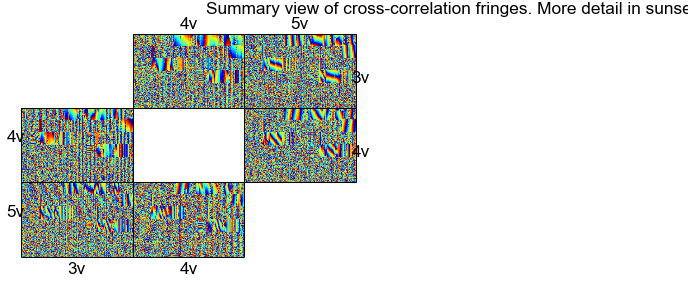

In [40]:
fig = plt.figure()
for sw in range(n_spw):
  for pol in ('h','v'):
    i = 0 if pol == 'h' else 1
    fringe = np.vstack(fringes[i::2])
    #For plotting the fringes
    fig.subplots_adjust(wspace=0., hspace=0.)
    for n, (indexA, indexB) in enumerate(crosscorr):
      subplot_index = (num_ants * indexA + indexB + 1) if pol == 'h' else (indexA + num_ants * indexB + 1)
      ax = fig.add_subplot(num_ants, num_ants, subplot_index)
      ax.imshow(fringe[:,:,n])
      ax.set_aspect('auto')
      ax.set_xticks([])
      ax.set_yticks([])
      if pol == 'h':
        if indexA == 0:
          ax.xaxis.set_label_position('top')
          ax.set_xlabel(h5.inputs[indexB][3:],size='xx-large')
        if indexB == len(h5.ants) - 1:
          ax.yaxis.set_label_position('right')
          ax.set_ylabel(h5.inputs[indexA][3:], rotation='horizontal',size = 'xx-large')
      else:
        if indexA == 0:
          ax.set_ylabel(h5.inputs[indexB][3:], rotation='horizontal',size='xx-large')
        if indexB == len(h5.ants) - 1:
          ax.set_xlabel(h5.inputs[indexA][3:],size='xx-large')
plt.annotate('Summary view of cross-correlation fringes. More detail in sunsequent pages.',(0.2,0.95),xycoords='figure fraction',xytext=(0.3, 0.95), textcoords='figure fraction',fontsize='xx-large')

In [41]:
print ants
ant = ants[0]
print ant

[<katpoint.Antenna 'ant3' diam=12.0m at 0x7fcb78795a50>, <katpoint.Antenna 'ant4' diam=12.0m at 0x7fcb78795590>, <katpoint.Antenna 'ant5' diam=12.0m at 0x7fcb78770110>]
ant3: 12-m dish at ENU offset [  3.98505000e+00   2.69086000e+01  -1.25500000e-02] m from lat -30:43:17.3, long 21:24:38.5, alt 1038.0 m


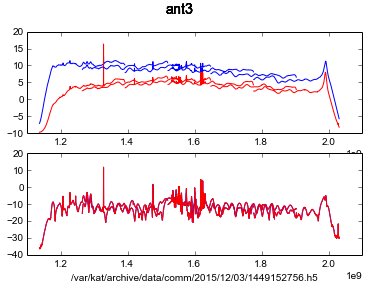

In [42]:
plt.figure()
ymin,ymax = 20,5
a = int(ant.name[-1:])
i=0
for sw in range(n_spw):
  try:
    h5.select(spw=sw)
    for scan_index, state, target in h5.scans():
      ts = h5.timestamps[:] # to determine if the scans are of zero length
      if state != 'track' or len(ts) < 2: continue
      h5.select(ants = ant.name,channels=ch)
      power = np.abs(h5.vis[:,:,:])
      f_ind = h5.channel_freqs
      dB_power = 10 * np.log10(np.median(power,0))
      for i in range(2):
        plt.subplot(211)
        plt.plot(f_ind,dB_power[:,i],color = colors[i%3])
        plt.subplot(212)
        plt.plot(f_ind,dB_power[:,3],color = colors[i%3])
  except KeyError , error:
    print 'Failed to read scans from File: ',fullname,' with Key Error:',error
  except ValueError , error:
    print 'Failed to read scans from File: ',fullname,' with Value Error:',error
  plt.xlabel(fullname)
  plt.annotate(ant.name,(0.45,0.95),xycoords='figure fraction', \
               xytext=(0.45, 0.95), textcoords='figure fraction',fontsize='x-large')